In [1]:
import numpy as np
import scipy.optimize as opt
from multiprocessing import Pool
import multiprocessing
import pandas as pd
from bpmf import prepare_data,bayes_PCA_potential
import copy
import time
from optimize import optimize_parallel_new
from baselines import GenerateSigma,construct_ESVM_kernel,set_function

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.__version__

'1.17.1'

In [3]:
data_train = pd.read_csv('ml-100k/ua.base', sep="\t", header=None)
data_test = pd.read_csv('ml-100k/ua.test', sep="\t", header=None)

Prepare small part of dataset ($10019$ observations train, corresponding to $100$ users), and full dataset with $10$ movies for each user reserved as test.

In [4]:
#X_train_small,X_test_small,Y_train_small,Y_test_small = prepare_data(data_train,data_test,size="small")
#size = "full" #otherwise select "full"
size = "full"
Train,Test = prepare_data(data_train,data_test,size=size)
print(len(Train))
print(len(Test))
Train[:,:-1] -= 1
Test[:,:-1] -= 1

90570
9430


Create potential with respective paramters

In [5]:
#fix variance for Y_{i,j}
tau = 3.0
#fix batch size
batch_size = 5000
#latent space dimension
D = 5
#number of films and users
N_users = 1+np.max(Train[:,0])
N_films = 1+max(np.max(Train[:,1]),np.max(Test[:,1]))
print("users = ",N_users)
print("films = ",N_films)

users =  943
films =  1682


In [6]:
Cur_pot = bayes_PCA_potential(D,Train,Test,tau,batch_size,N_users,N_films,1812)

dimension =  15750


Run SGLD with randomly generated weights $\lambda_U,\lambda_V,\lambda_a,\lambda_b$

In [7]:
r_seed = 1453
step = 1e-4
#step = 1e-5
N_burn = 0
#during burn-in
N_steps_burn = 1000
#N_loops_burn = 50
N_loops_burn = 50
#during the main optimization
N_steps_main = 4000
N_loops_main = 1
#number of gradient descent iterations
N_opt = 10000
step_opt = 1e-4
#compute test error each ... steps
ctrl_steps = 1

In [8]:
#training trajectories
traj = np.zeros((1,N_steps_main // ctrl_steps,Cur_pot.total_dim),dtype = float)
traj_grad = np.zeros((1,N_steps_main // ctrl_steps,Cur_pot.total_dim),dtype = float)
mse_train = np.zeros((1,N_steps_main // ctrl_steps,1),dtype=float)
mse_test = np.zeros((1,N_steps_main // ctrl_steps,1),dtype=float)
#validation trajectories
traj_val = np.zeros((1,N_steps_main // ctrl_steps,Cur_pot.total_dim),dtype = float)
traj_grad_val = np.zeros((1,N_steps_main // ctrl_steps,Cur_pot.total_dim),dtype = float)
mse_train_val = np.zeros((1,N_steps_main // ctrl_steps,1),dtype=float)
mse_test_val = np.zeros((1,N_steps_main // ctrl_steps,1),dtype=float)

SGLD pipeline

In [ ]:
start_time = time.time()
for i in range(N_loops_burn):
    cur_traj,cur_traj_grad,train_err,test_err = Cur_pot.SGLD(N_burn,N_steps_burn,step,ctrl_steps,r_seed+i)
    Cur_pot.update_weights(r_seed+i)
print("time taken = ",time.time()-start_time)

SGLD-FP pipeline

In [9]:
start_time = time.time()
sample_train_err = np.zeros(N_loops_burn*N_steps_burn//ctrl_steps)
sample_test_err = np.zeros(N_loops_burn*N_steps_burn//ctrl_steps)
for i in range(N_loops_burn):
    if i == 0:
        N_opt = 10000
    else:
        N_opt = 1000
    cur_traj,cur_traj_grad,train_err,test_err = Cur_pot.SGLD_FP(N_opt,N_steps_burn,step_opt,step,ctrl_steps,r_seed+i)
    sample_train_err[i*len(train_err):(i+1)*len(train_err)] = train_err
    sample_test_err[i*len(test_err):(i+1)*len(test_err)] = test_err
    Cur_pot.update_weights(r_seed+i)
print("time taken = ",time.time()-start_time)

time taken =  364.40755128860474


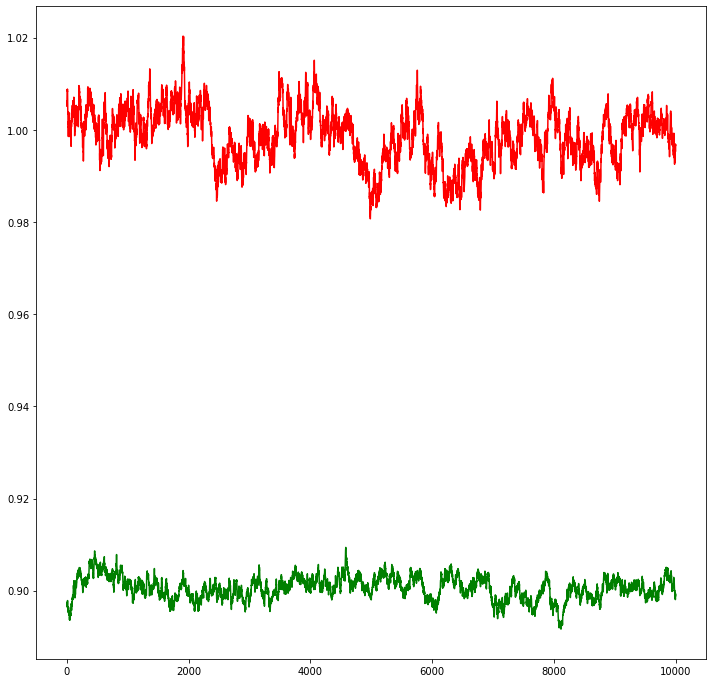

In [10]:
plt.figure(figsize = (12,12))
plt.plot(sample_train_err[40000:],c='g',label='Train MSE')
plt.plot(sample_test_err[40000:],c='r',label='Test MSE')
plt.show()

Now we can run "warmed-up" chain for SGLD

In [ ]:
start_time = time.time()
for i in range(N_loops_main):
    cur_traj,cur_traj_grad,train_err,test_err = Cur_pot.SGLD(N_burn,N_steps_main,step,ctrl_steps,r_seed+i)
    traj[0,:,:] = cur_traj
    traj_grad[0,:,:] = cur_traj_grad
    mse_train[0,:,0] = train_err
    mse_test[0,:,0] = test_err
    #Cur_pot.update_weights(r_seed+i)
print("time taken = ",time.time()-start_time)

Or we can run "warmed-up" chain for SGLD-FP

In [11]:
start_time = time.time()
N_opt = 5000
for i in range(N_loops_main):
    cur_traj,cur_traj_grad,train_err,test_err = Cur_pot.SGLD_FP(N_opt,N_steps_main,step_opt,step,ctrl_steps,r_seed+i)
    traj[0,:,:] = cur_traj
    traj_grad[0,:,:] = cur_traj_grad
    mse_train[0,:,0] = train_err
    mse_test[0,:,0] = test_err
    #Cur_pot.update_weights(r_seed+i)
print("time taken = ",time.time()-start_time)

time taken =  29.769232511520386


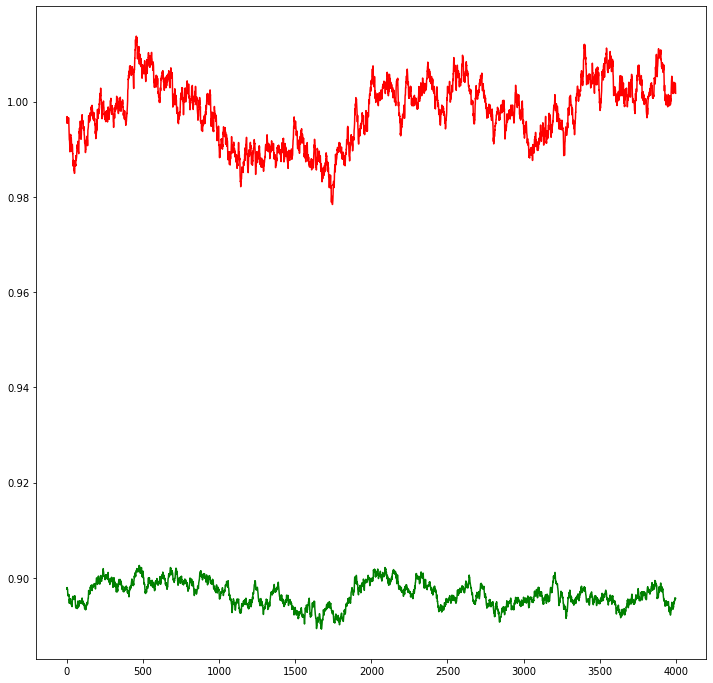

In [12]:
plt.figure(figsize = (12,12))
plt.plot(mse_train[0,:,0],c='g',label='Train MSE')
plt.plot(mse_test[0,:,0],c='r',label='Test MSE')
plt.show()

Prepare validation dataset in the same manner

In [ ]:
start_time = time.time()
for i in range(N_loops_main):
    cur_traj,cur_traj_grad,train_err,test_err = Cur_pot.SGLD(N_burn,N_steps_main,step,ctrl_steps,666)
    traj_val[0,:,:] = cur_traj
    traj_grad_val[0,:,:] = cur_traj_grad
    mse_train_val[0,:,0] = train_err
    mse_test_val[0,:,0] = test_err
    #Cur_pot.update_weights(r_seed+i)
print("time taken = ",time.time()-start_time)

In [14]:
#FP
start_time = time.time()
N_opt = 0
for i in range(N_loops_main):
    cur_traj,cur_traj_grad,train_err,test_err = Cur_pot.SGLD_FP(N_opt,N_steps_main,step_opt,step,ctrl_steps,666)
    traj_val[0,:,:] = cur_traj
    traj_grad_val[0,:,:] = cur_traj_grad
    mse_train_val[0,:,0] = train_err
    mse_test_val[0,:,0] = test_err
    #Cur_pot.update_weights(r_seed+i)
print("time taken = ",time.time()-start_time)

time taken =  26.966896772384644


Plot ACF for training data

In [ ]:
from statsmodels.tsa.stattools import acf
sample_acf = acf(mse_test[0,:,0], unbiased = True, nlags = 500, fft = True)

plt.figure(figsize=(20,5))
plt.title('Sample  ACF',fontsize=16)
plt.plot(sample_acf, label='sample acf')
plt.legend(fontsize=16)

plt.show()

In [ ]:
N_train = N_steps_main // ctrl_steps
print(N_train)
W_train_spec = construct_ESVM_kernel(N_train)
inds_arr = np.array([0])
degree = 1 #degree of the polynomial
opt_structure_train = {
    "W":W_train_spec,
    "n_restarts": 1, # Number of restarts during optimization,
    "sigma": 0.0001, # Deviation of starting points
    "tol": 1e-6, # Tolerance (for the norm of gradient)
    "alpha": 1.0, # Ridge penalty for 2nd order control functionals
    "beta": 1e2 # smoothing parameter in the softmax
}
methods = ["EVM"]

In [ ]:
#%lsmagic
#%mprun optimize_parallel_new(degree,inds_arr,mse_test,traj,traj_grad,opt_structure_train,methods)

In [ ]:
coef_dict_k_deg = optimize_parallel_new(degree,inds_arr,mse_test,traj,traj_grad,opt_structure_train,methods)

In [ ]:
print(traj.shape)
print(traj_grad.shape)
print(mse_test.shape)

In [15]:
N = traj.shape[1]
#P = np.eye(N) - 1./N*np.ones((N,N))
#W = 1./N*np.eye(N)
#A_vspom = P.dot(W.dot(P))
A_vspom = (np.eye(N) - 1./N*np.ones((N,N))).dot((1./N*np.eye(N)).dot(np.eye(N) - 1./N*np.ones((N,N))))
#main matrix
Matr = (traj_grad[0,:,:].T).dot(A_vspom.dot(traj_grad[0,:,:]))
f = -(traj_grad[0,:,:].T).dot(A_vspom.dot(mse_test[0,:,0]))
print(Matr.shape)
print(f.shape)

(15750, 15750)
(15750,)


In [16]:
alpha = 1.0
Matr_pinv = np.linalg.pinv(Matr + alpha*np.eye(Matr.shape[1]),hermitian = True)
cfs = Matr_pinv @ f

Evaluate on the training data

In [17]:
mse_test_updated = mse_test[0,:,0] + traj_grad[0,:,:] @ cfs
print(mse_test_updated)

[0.99785984 0.99786703 0.99785111 ... 0.99786561 0.9978722  0.99786232]


In [18]:
print(np.mean(mse_test))
print(np.std(mse_test))
print(np.mean(mse_test_updated))
print(np.std(mse_test_updated))

0.9977335729162827
0.006532060207725737
0.9978641167941616
7.812066302711032e-06


Evaluate on validation dataset

In [19]:
mse_test_val_evm = mse_test_val[0,:,0] + traj_grad_val[0,:,:] @ cfs
print(mse_test_val_evm)
print(np.std(mse_test_val_evm))

[1.00030585 1.0012547  1.00344314 ... 1.06388229 1.06869812 1.05565186]
0.009581015408352015


In [20]:
print(np.mean(mse_test_val))
print(np.std(mse_test_val))
print(np.mean(mse_test_val_evm))
print(np.std(mse_test_val_evm))

1.0547215362135116
0.009089304613443176
1.0542743639675254
0.009581015408352015


Evaluating ESVM

In [ ]:
print(cfs)
print(np.linalg.norm(cfs))
N = traj.shape[1]
A_vspom = (np.eye(N) - 1./N*np.ones((N,N))).dot((1./N*np.eye(N)).dot(np.eye(N) - 1./N*np.ones((N,N))))
mse_test_updated = mse_test[0,:,0] + traj_grad[0,:,:] @ cfs
print(np.dot(mse_test_updated,A_vspom @ mse_test_updated))
A_upd = (np.eye(N) - 1./N*np.ones((N,N))).dot((1./N*construct_ESVM_kernel_updated(N)).dot(np.eye(N) - 1./N*np.ones((N,N))))
print(np.linalg.norm(cfs_esvm))
mse_test_esvm = mse_test[0,:,0] + traj_grad[0,:,:] @ cfs_esvm
print(np.dot(mse_test_esvm,A_vspom @ mse_test_esvm))
print(np.dot(mse_test_esvm,A_upd @ mse_test_esvm))
print(np.dot(mse_test_updated,A_upd @ mse_test_updated))

Now find the vector of coefficients

In [ ]:
#coefs_esvm = Matr_pinv @ f
mse_test_updated = mse_test[0,:,0] + traj_grad[0,:,:] @ cfs
print(mse_test_updated)
print(np.std(mse_test_updated))

In [ ]:
print(np.mean(mse_test))
print(np.std(mse_test))
print(np.mean(mse_test_updated))
print(np.std(mse_test_updated))

Now the similar workout with ESVM kernel

In [21]:
from scipy.sparse import diags
from scipy.linalg import toeplitz

def construct_ESVM_kernel(n):
    """
    construct toeplitz matrix W of given size W, to estimate spectral variance with piecewise-linear kernel
    Arguments:
        n - int, size of the matrix;
    Returns:
        W - csr matrix;
    """
    bn = 50
    trap_left = np.linspace(0,1,bn)
    trap_center = np.ones(2*bn+1,dtype = float)
    trap_right = np.linspace(1,0,bn)
    diag_elems = np.concatenate([trap_left,trap_center,trap_right])
    W = diags(diag_elems,np.arange(-2*bn,2*bn+1),shape = (n,n))
    return W.toarray()

def construct_ESVM_kernel_updated(n):
    """
    construct toeplitz matrix W of given size W, to estimate spectral variance with piecewise-linear kernel
    Arguments:
        n - int, size of the matrix;
    Returns:
        W - csr matrix;
    """
    bn = 50
    diag_elems = 1./2 + 1./2*np.cos(np.pi/bn*np.arange(-bn,bn+1))
    W = diags(diag_elems,np.arange(-bn,bn+1),shape = (n,n))
    return W.toarray()

def construct_ESVM_kernel_exp(n):
    """
    """
    h = 10.0
    c = np.exp(-(np.arange(n)/h)**2)
    W = toeplitz(c)
    return W

In [22]:
#A = construct_ESVM_kernel_exp(5)
#print(A)
#U = np.linalg.eigvalsh(A)
#print(U)
#print(sorted(U))

In [23]:
#A = construct_ESVM_kernel(1000)
#print(A)
#print(np.max(A - A.T))
#U = np.linalg.eigvalsh(A)
#print(U)
#print(sorted(U))

In [24]:
#A = construct_ESVM_kernel(50)
#print(A[0])

NameError: name 'acf' is not defined

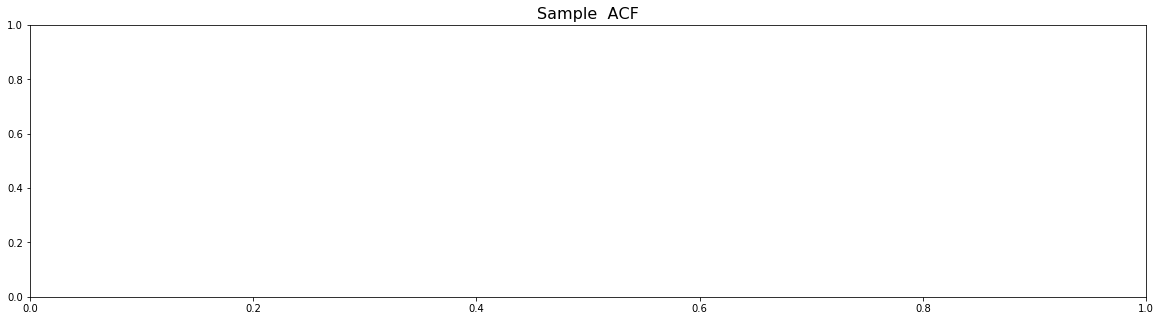

In [25]:
plt.figure(figsize=(20,5))
plt.title('Sample  ACF',fontsize=16)
plt.plot(acf(mse_test[0,:,0], unbiased = True, nlags = 100, fft = True), label='sample acf', c= 'g')
plt.plot(acf(mse_test_updated, unbiased = True, nlags = 100, fft = True), label='sample acf', c = 'r')
plt.legend(fontsize=16)

plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.title('Sample  ACF',fontsize=16)
plt.plot(acf(mse_test_val[0,:,0], unbiased = True, nlags = 100, fft = True), label='sample acf', c= 'g')
plt.plot(acf(mse_test_val_evm, unbiased = True, nlags = 100, fft = True), label='sample acf', c = 'r')
plt.legend(fontsize=16)

plt.show()

In [ ]:
plt.figure(figsize = (12,12))
plt.plot(mse_test_val_evm,c='g',label='Test MSE updated')
plt.plot(mse_test_val[0,:,0],c='r',label='Test MSE')
#plt.plot(mse_test_updated,c='b',label='Test MSE updated')
plt.show()

In [ ]:
#print(traj.shape)
traj = traj[:,1000:,:]
traj_grad = traj_grad[:,1000:,:]
print(traj.shape)
print(traj_grad.shape)

In [ ]:
mse_test = mse_test[:,1000:,]

In [26]:
N = traj.shape[1]
print(N)
#P = np.eye(N) - 1./N*np.ones((N,N))
#W = 1./N*np.eye(N)
#A_vspom = P.dot(W.dot(P))
A_vspom = (np.eye(N) - 1./N*np.ones((N,N))).dot((1./N*construct_ESVM_kernel(N)).dot(np.eye(N) - 1./N*np.ones((N,N))))
#main matrix
Matr_new = (traj_grad[0,:,:].T).dot(A_vspom.dot(traj_grad[0,:,:]))
f_new = -(traj_grad[0,:,:].T).dot(A_vspom.dot(mse_test[0,:,0]))
print(Matr_new.shape)
print(f_new.shape)

4000
(15750, 15750)
(15750,)


In [27]:
alpha = 0.1
Matr_new_pinv = np.linalg.pinv(Matr_new + alpha*np.eye(Matr_new.shape[1]),hermitian = True)

In [28]:
cfs_esvm = Matr_new_pinv @ f_new
print(cfs_esvm)
#print(cfs)
#print(np.linalg.norm(cfs))
print(np.linalg.norm(cfs_esvm))

[ 1.45232938e-06 -7.26114588e-07 -1.11483219e-06 ...  5.92915295e-07
  8.90047955e-07 -1.32616210e-06]
0.000128482786971404


In [29]:
mse_test_esvm = mse_test[0,:,0] + traj_grad[0,:,:] @ cfs_esvm
print(np.mean(mse_test))
print(np.std(mse_test))
#print(np.mean(mse_test_updated))
#print(np.std(mse_test_updated))
print(mse_test_esvm)
print(np.std(mse_test_esvm))
###
print(np.dot(mse_test_esvm,A_vspom @ mse_test_esvm))
#print(np.dot(mse_test_updated,A_vspom @ mse_test_updated))

0.9977335729162827
0.006532060207725737
[0.9975097  1.00102556 0.99397666 ... 0.99838861 0.99837569 0.99805578]
0.0014660488393970568
-6.305827884487827e-10


Validate on test data

In [30]:
mse_test_val_esvm = mse_test_val[0,:,0] + traj_grad_val[0,:,:] @ cfs_esvm
print(mse_test_val_esvm)
print(np.std(mse_test_val_esvm))

[1.00041625 1.0014322  1.00441751 ... 1.0656034  1.0681346  1.05901604]
0.009759861563588726


In [31]:
print(np.mean(mse_test_val))
print(np.std(mse_test_val))
print(np.mean(mse_test_val_esvm))
print(np.std(mse_test_val_esvm))

1.0547215362135116
0.009089304613443176
1.0544058685687174
0.009759861563588726


Plots and comparisons of acfs

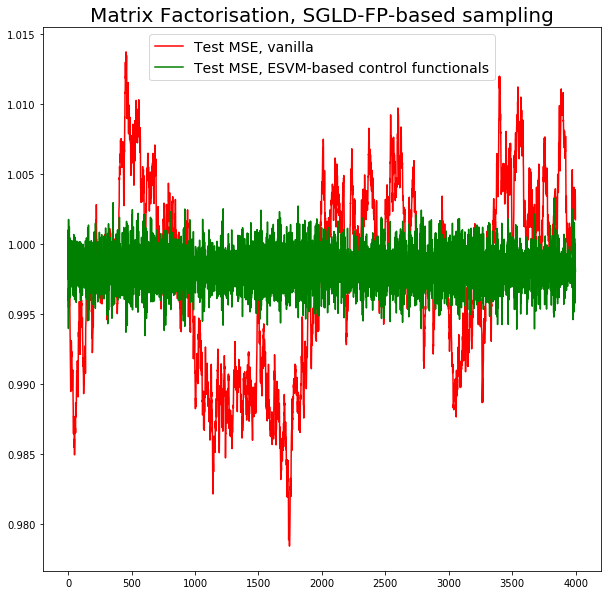

In [32]:
plt.figure(figsize = (10,10))
plt.title("Matrix Factorisation, SGLD-FP-based sampling",fontsize=20)
plt.plot(mse_test[0,:,0],c='r',label='Test MSE, vanilla')
plt.plot(mse_test_esvm,c='g',label='Test MSE, ESVM-based control functionals')
plt.legend(fontsize=14)
#plt.plot(mse_test_updated,c='b',label='Test MSE updated')
plt.show()

In [ ]:
import seaborn as sns
def plot_quantiles(data, title, labels):
    meanprops = dict(linestyle='-', linewidth=1, color='black')
    medianprops = dict(linestyle='', linewidth=0)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 4), sharey=True, frameon=False,dpi=100)      
    fig.suptitle(title, fontsize=20)
    parts = ax1.boxplot(data,  widths=0.6, patch_artist=True, meanline=True, showmeans=True, medianprops=medianprops,meanprops = meanprops, showfliers=False)
    set_axis_style_boxplot(ax1, labels, parts)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()  
    
def set_axis_style_boxplot(ax, labels, parts):
    colors = (sns.color_palette("muted")[1:5])
    ax.grid(color='black', linestyle='-', linewidth=0.15, alpha=0.6)    
    ax.set_xticks(np.arange(1, len(labels)+1))
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_xlim(0.5, len(labels) + 0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    for pc,i in zip(parts['boxes'],range(len(labels))):
        pc.set(facecolor=colors[i],alpha=0.65)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.65)

In [ ]:
data = np.asarray([mse_test[0,:,0],mse_test_esvm])
print(data.shape)
print(data.T.shape)
plot_quantiles(data.T,"Test MSE, SGLD-FP-based sampling",["Vanilla","ESVM"])

In [ ]:
plt.figure(figsize = (12,12))

plt.plot(mse_test_val_esvm,c='g',label='Test MSE updated')
plt.plot(mse_test_val[0,:,0],c='r',label='Test MSE')
#plt.plot(mse_test_val_evm,c='b',label='Test MSE updated')
plt.show()

In [ ]:
plt.figure(figsize = (12,12))
plt.plot(mse_test_val_evm,c='b',label='Test MSE updated')
plt.plot(mse_test_val[0,:,0],c='r',label='Test MSE')
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.title('Sample  ACF',fontsize=16)
plt.plot(acf(mse_test_val[0,:,0], unbiased = True, nlags = 100, fft = True), label='sample acf vanilla', c= 'g')
plt.plot(acf(mse_test_val_esvm, unbiased = True, nlags = 100, fft = True), label='sample acf ESVM', c = 'r')
plt.plot(acf(mse_test_val_evm, unbiased = True, nlags = 100, fft = True), label='sample acf EVM', c = 'b')
plt.legend(fontsize=16)

plt.show()

In [ ]:
print(np.mean(mse_test_updated))

In [ ]:
print(np.linalg.norm(Matr @ coefs_esvm - f))

In [ ]:
#x = np.linalg.lstsq(Matr,f)

In [ ]:
print(coef_dict_k_deg['LS'])

In [ ]:
print(coef_dict_k_deg['EVM'])

In [ ]:
print(np.mean(mse_test))

In [ ]:
print(np.std(mse_test))

In [ ]:
print(coef_dict_k_deg['EVM'].shape)
print(traj_grad.shape)
mse_test_updated = mse_test[0,:,0] + traj_grad[0,:,:] @ coef_dict_k_deg['EVM'][0,:]
print(mse_test_updated)
print(np.std(mse_test_updated))

In [ ]:
mse_test_updated = mse_test[0,:,0] + traj_grad[0,:,:] @ coef_dict_k_deg['EVM'][0,:]
print(np.std(mse_test_updated))
mse_test_updated = mse_test[0,:,0] + traj_grad[0,:,:] @ coef_dict_k_deg['LS'][0,:]
print(np.std(mse_test_updated))